In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import kstest, ttest_ind, mannwhitneyu, zscore
from scipy.stats import mannwhitneyu

df = pd.read_csv('creditcard_2023.csv')
print(df.shape[0])

568630


In [2]:
df.info('creditcard_2023.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

In [3]:
df.isnull().sum()
df = df.drop(columns=['id'])

Проверка баланса классов

In [4]:
df['Class'].value_counts()

Class
0    284315
1    284315
Name: count, dtype: int64

In [5]:
df['Class'].value_counts(normalize=True) * 100

Class
0    50.0
1    50.0
Name: proportion, dtype: float64

График распределения Class

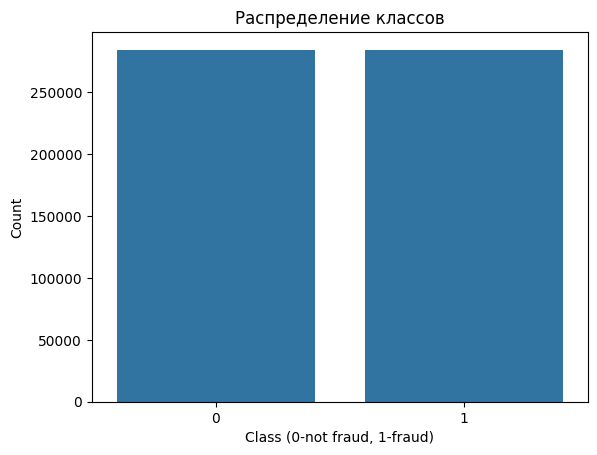

In [6]:
sns.countplot(x='Class', data=df)
plt.title('Распределение классов')
plt.xlabel('Class (0-not fraud, 1-fraud)')
plt.ylabel('Count')
plt.show()

Гистограмма

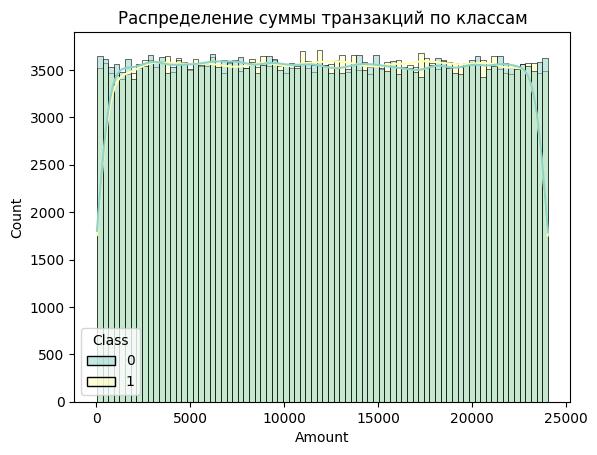

In [7]:
sns.histplot(data=df, x='Amount', hue='Class', bins=80, kde=True, palette='Set3')
plt.title('Распределение суммы транзакций по классам')
plt.show()

Boxplot

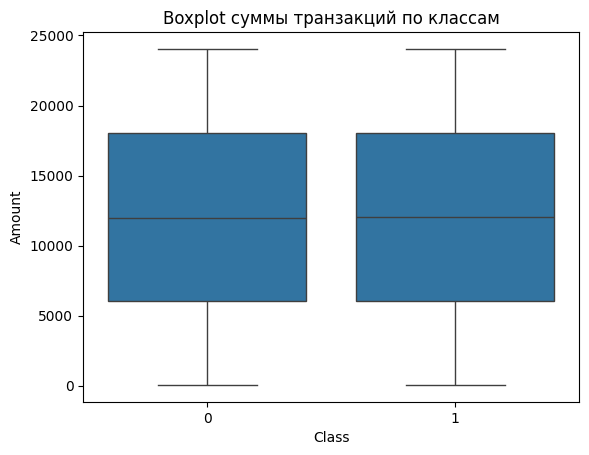

In [8]:
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Boxplot суммы транзакций по классам')
plt.xlabel('Class')
plt.ylabel('Amount')
plt.show()

Boxplot по V-признакам (V1–V28)

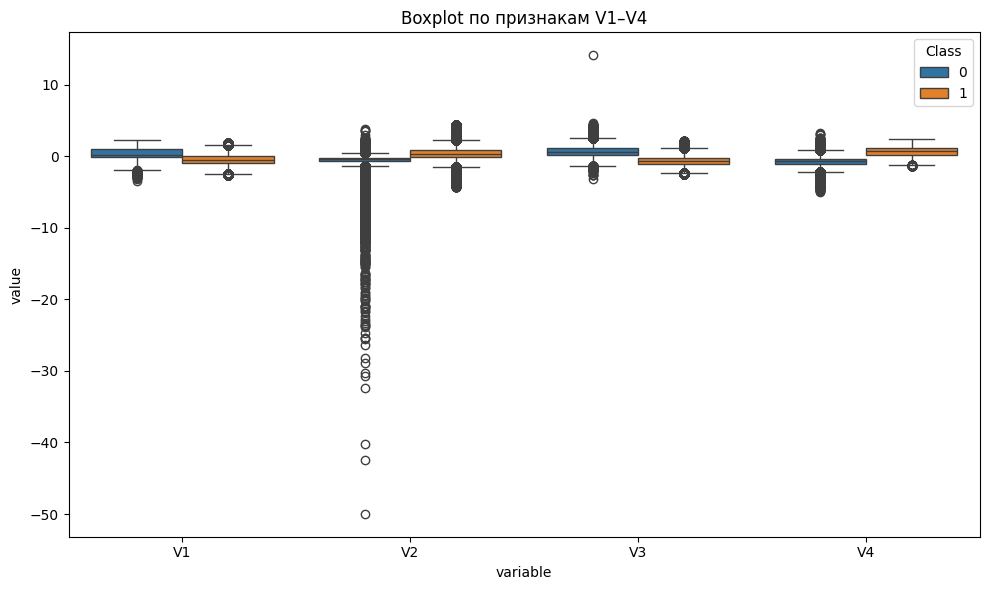

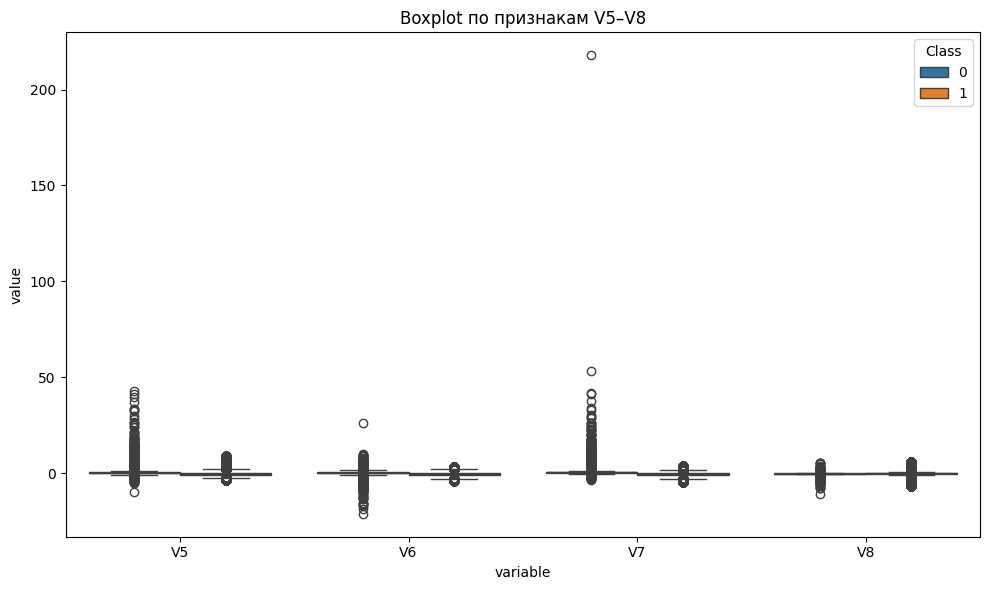

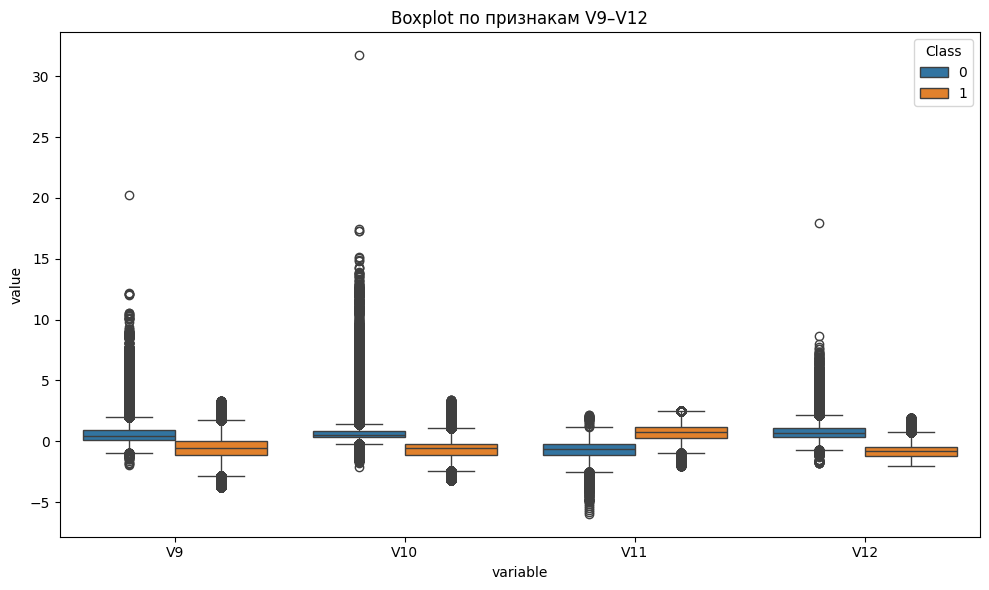

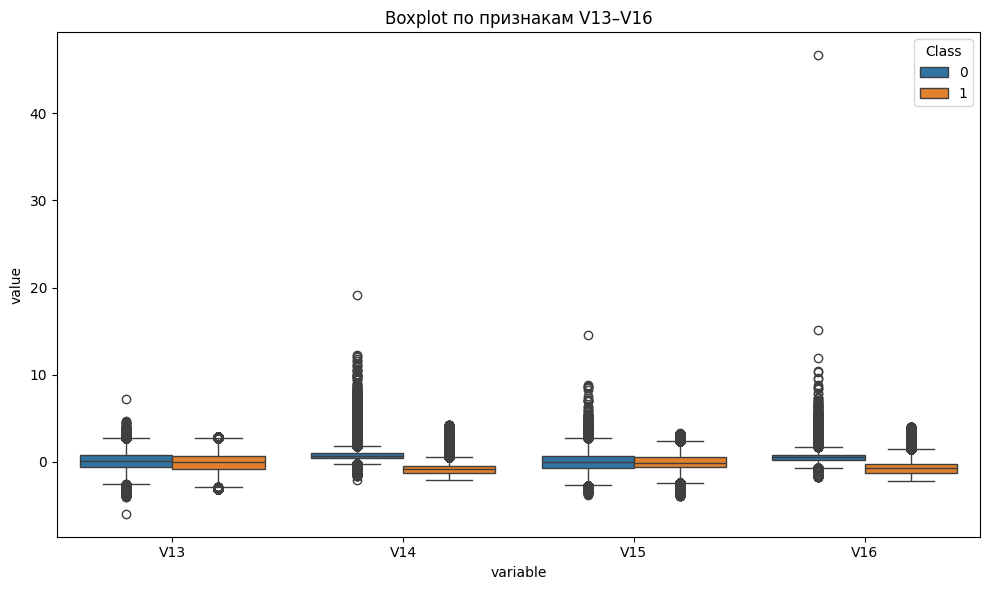

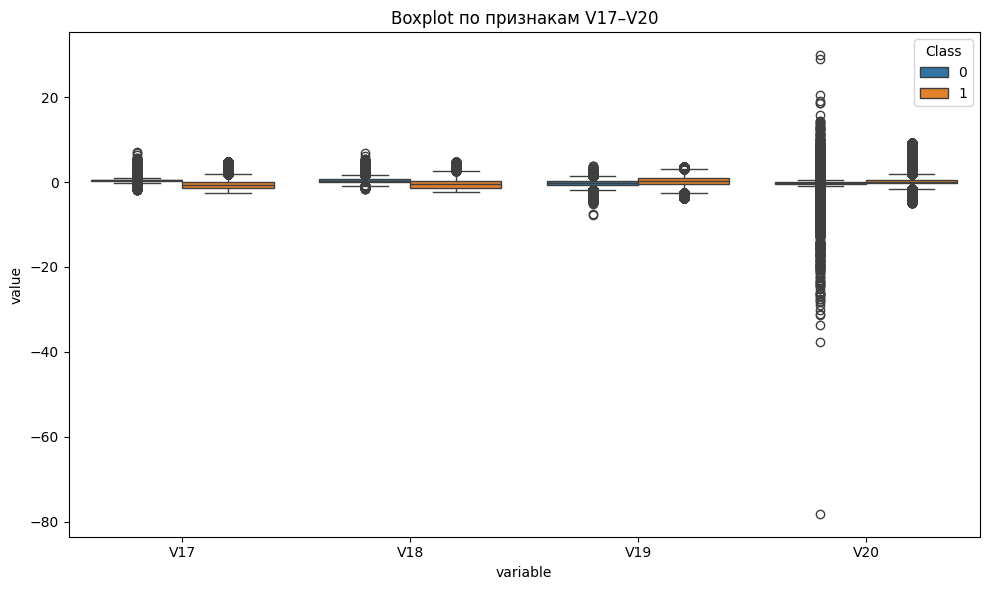

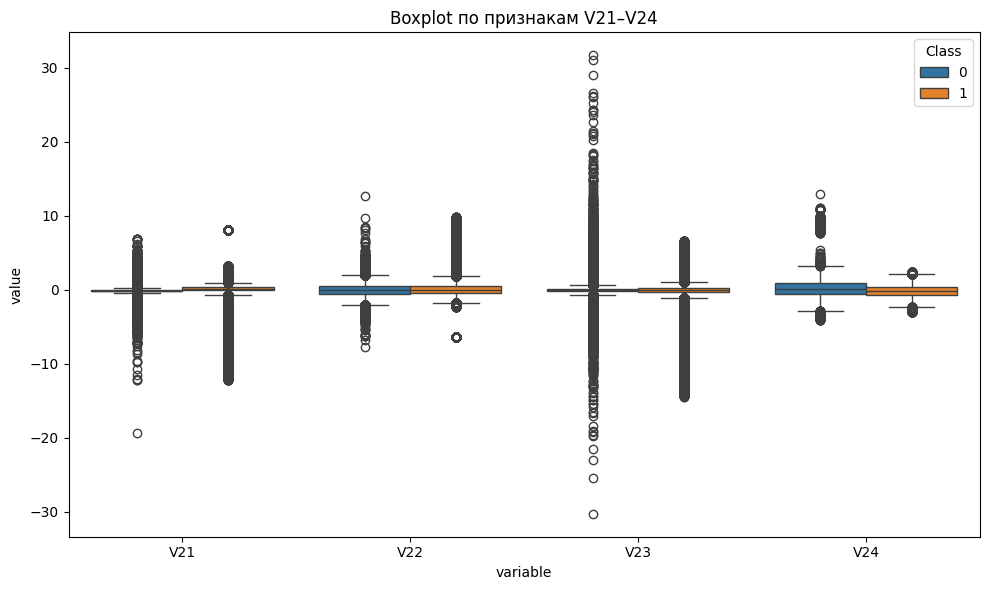

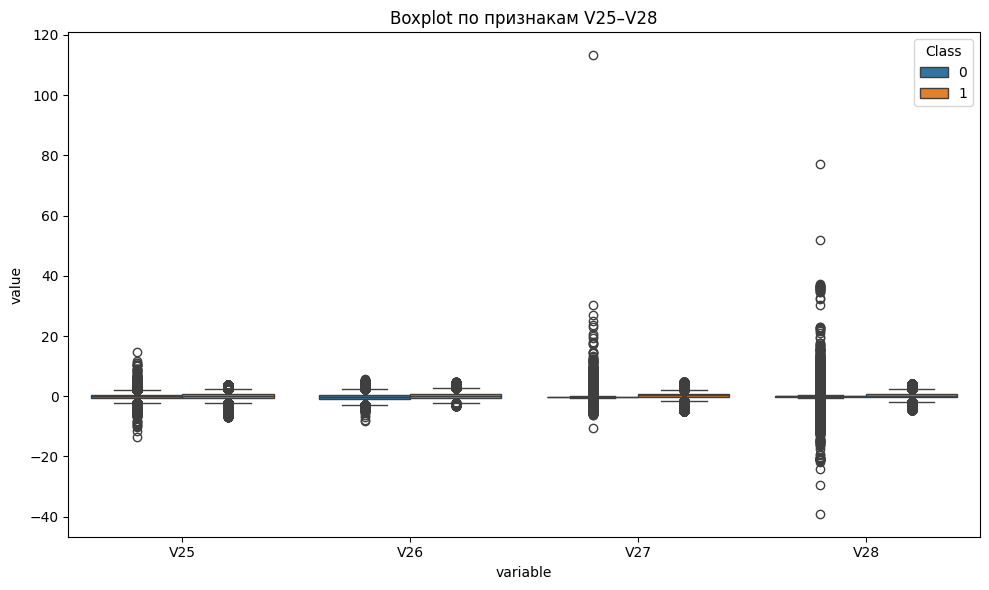

In [9]:
v_features = [f'V{i}' for i in range(1, 29)]

group_size = 4

for i in range(0, len(v_features), group_size):
    group = v_features[i:i+group_size]
    df_melt = df.melt(id_vars='Class', value_vars=group)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='variable', y='value', hue='Class', data=df_melt)
    plt.title(f'Boxplot по признакам {group[0]}–{group[-1]}')
    plt.legend(title='Class', loc='upper right')
    plt.tight_layout()
    plt.show()

Корреляционная матрица для V1–V28, Amount

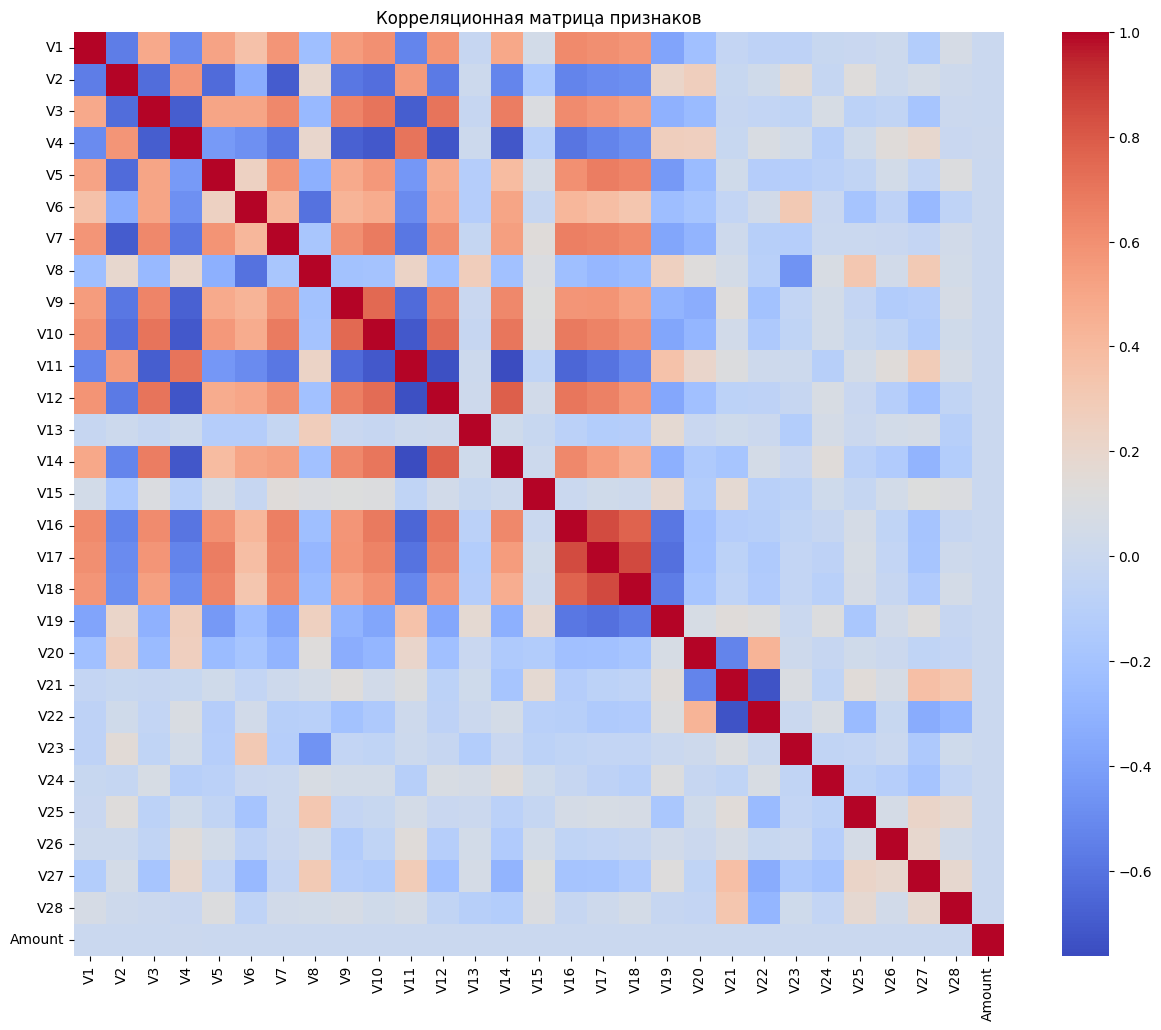

In [10]:
features = [f'V{i}' for i in range(1, 29)] + ['Amount']
corr_matrix = df[features].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Корреляционная матрица признаков')
plt.show()

Проверка нормальности распределения с помощью теста Shapiro-Wilk

In [11]:
amount_0 = df[df['Class'] == 0]['Amount']
amount_1 = df[df['Class'] == 1]['Amount']

amount_0_z = zscore(amount_0)
amount_1_z = zscore(amount_1)

ks_0 = kstest(amount_0_z, 'norm')
ks_1 = kstest(amount_1_z, 'norm')

print(f"K–S test (Class 0): p = {ks_0.pvalue:.4f}")
print(f"K–S test (Class 1): p = {ks_1.pvalue:.4f}")

K–S test (Class 0): p = 0.0000
K–S test (Class 1): p = 0.0000


Сравнение групп

In [12]:
def analyze_features_ks(df, class_col='Class', max_sample=5000):
    results = []
    features = [col for col in df.columns if col not in [class_col, 'id']]

    df0 = df[df[class_col] == 0]
    df1 = df[df[class_col] == 1]

    for col in features:
        x0 = df0[col].sample(min(len(df0), max_sample), random_state=42)
        x1 = df1[col].sample(min(len(df1), max_sample), random_state=42)

        p_norm0 = kstest(zscore(x0), 'norm').pvalue
        p_norm1 = kstest(zscore(x1), 'norm').pvalue
        is_normal = p_norm0 > 0.05 and p_norm1 > 0.05

        if is_normal:
            test = 't-test'
            p_val = ttest_ind(df0[col], df1[col], equal_var=False).pvalue
        else:
            test = 'Mann–Whitney'
            p_val = mannwhitneyu(df0[col], df1[col], alternative='two-sided').pvalue

        result = [
            col,
            f"{min(p_norm0, p_norm1):.10f}",
            test,
            f"{p_val:.10f}",
            'различия значимы' if p_val < 0.05 else 'нет различий'
        ]
        results.append(result)

    return pd.DataFrame(results, columns=['Признак', 'p-value (нормальность)', 'Тест', 'p-value (тест)', 'Вывод'])

results_df = analyze_features_ks(df)
print(results_df)

   Признак p-value (нормальность)          Тест p-value (тест)  \
0       V1           0.0000000000  Mann–Whitney   0.0000000000   
1       V2           0.0000000000  Mann–Whitney   0.0000000000   
2       V3           0.0000000000  Mann–Whitney   0.0000000000   
3       V4           0.0000000000  Mann–Whitney   0.0000000000   
4       V5           0.0000000000  Mann–Whitney   0.0000000000   
5       V6           0.0000000000  Mann–Whitney   0.0000000000   
6       V7           0.0000000000  Mann–Whitney   0.0000000000   
7       V8           0.0000000000  Mann–Whitney   0.0000000000   
8       V9           0.0000000000  Mann–Whitney   0.0000000000   
9      V10           0.0000000000  Mann–Whitney   0.0000000000   
10     V11           0.0000000000  Mann–Whitney   0.0000000000   
11     V12           0.0000000000  Mann–Whitney   0.0000000000   
12     V13           0.0065013986  Mann–Whitney   0.0000000000   
13     V14           0.0000000000  Mann–Whitney   0.0000000000   
14     V15

In [13]:
u_stat, p_value = mannwhitneyu(amount_0, amount_1, alternative='two-sided')
print(f"Mann–Whitney U: p-value = {p_value:.4f}")

Mann–Whitney U: p-value = 0.0882


Доверительные интервалы (95%)

In [14]:
def conf_interval(data, conf=0.95):
    mean = np.mean(data)
    sem = st.sem(data)
    h = sem * st.t.ppf((1 + conf) / 2., len(data)-1)
    return mean, mean - h, mean + h

features = ['V25', 'V26', 'V27', 'Amount']

results = []

for feature in features:
    for cls in [0, 1]:
        values = df[df['Class'] == cls][feature]
        mean, low, high = conf_interval(values)
        results.append({
            'Признак': feature,
            'Класс': cls,
            'Среднее': round(mean, 6),
            'Нижняя граница CI': round(low, 6),
            'Верхняя граница CI': round(high, 6)
        })

ci_df = pd.DataFrame(results)
print(ci_df)

  Признак  Класс       Среднее  Нижняя граница CI  Верхняя граница CI
0     V25      0     -0.061847          -0.064936           -0.058758
1     V25      1      0.061847           0.057679            0.066015
2     V26      0     -0.071052          -0.075033           -0.067071
3     V26      1      0.071052           0.067730            0.074374
4     V27      0     -0.214002          -0.215878           -0.212126
5     V27      1      0.214002           0.209283            0.218721
6  Amount      0  12026.313506       12000.842154        12051.784858
7  Amount      1  12057.601763       12032.203007        12083.000519


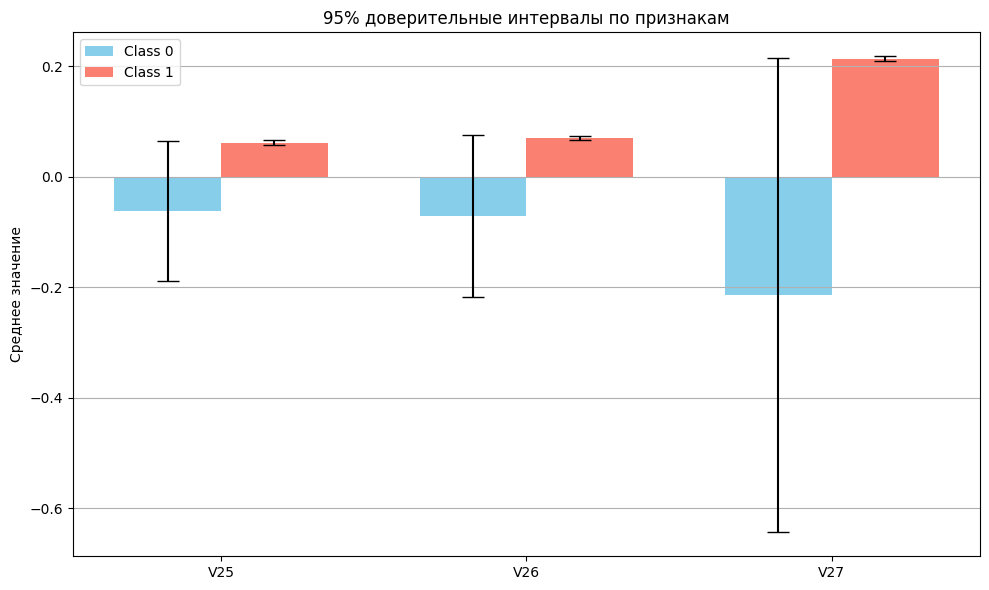

In [15]:
features = ['V25', 'V26', 'V27']
means_0 = [-0.061847, -0.071052, -0.214002]
means_1 = [0.061847,  0.071052,  0.214002]

errors_0 = [0.064936 - (-0.061847), 0.075033 - (-0.071052), 0.215878 - (-0.214002)]
errors_1 = [0.066015 - 0.061847, 0.074374 - 0.071052, 0.218721 - 0.214002]

x = np.arange(len(features))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars0 = ax.bar(x - width/2, means_0, width, yerr=errors_0, capsize=8, label='Class 0', color='skyblue')
bars1 = ax.bar(x + width/2, means_1, width, yerr=errors_1, capsize=8, label='Class 1', color='salmon')

ax.set_xticks(x)
ax.set_xticklabels(features)
ax.set_ylabel('Среднее значение')
ax.set_title('95% доверительные интервалы по признакам')
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()


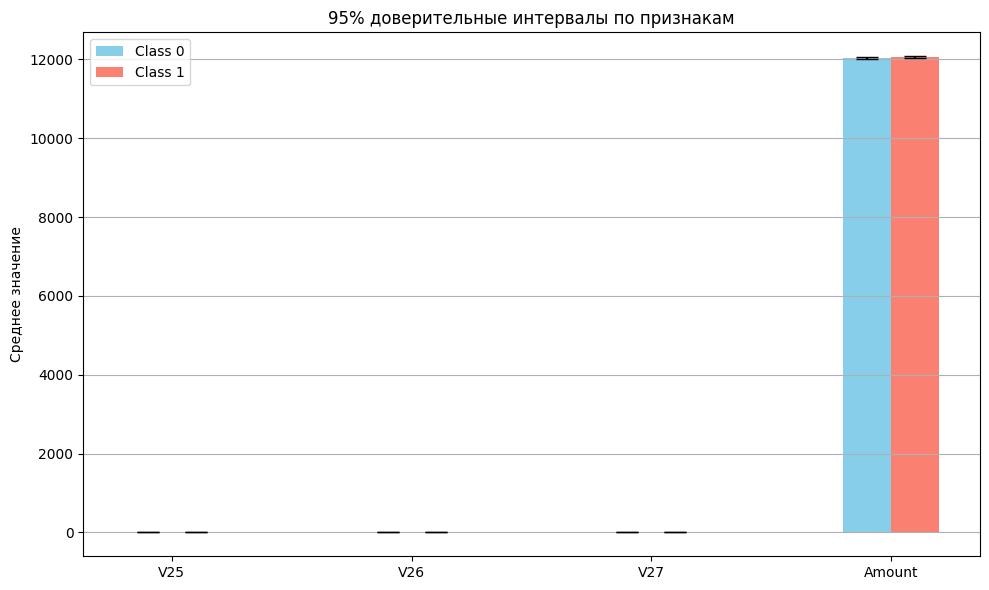

In [16]:
features = ['V25', 'V26', 'V27', 'Amount']
means_0 = [-0.061847, -0.071052, -0.214002, 12026.313506]
means_1 = [0.061847,  0.071052,  0.214002, 12057.601763]

errors_0 = [0.064936 - (-0.061847), 0.075033 - (-0.071052), 0.215878 - (-0.214002), 12026.313506 - 12000.842154]
errors_1 = [0.066015 - 0.061847, 0.074374 - 0.071052, 0.218721 - 0.214002, 12083.000519 - 12057.601763]

x = np.arange(len(features))
width = 0.2

# Построение графика
fig, ax = plt.subplots(figsize=(10, 6))

bars0 = ax.bar(x - width/2, means_0, width, yerr=errors_0, capsize=8, label='Class 0', color='skyblue')
bars1 = ax.bar(x + width/2, means_1, width, yerr=errors_1, capsize=8, label='Class 1', color='salmon')

ax.set_xticks(x)
ax.set_xticklabels(features)
ax.set_ylabel('Среднее значение')
ax.set_title('95% доверительные интервалы по признакам')
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()
